Running HMC with dual averaging and trajectory length 0.20...
1.0
2.0
4.0
find_reasonable_epsilon= 4.0
Done. Final epsilon = 1.871827.
(M+Madapt) / Functions called: 0.706215
(100000, 2)
(27886,)
0.17189299178194553
3
Percentiles
[[-1.540225   -0.78486745]
 [-0.0201502  -0.00258366]
 [ 1.58824289  0.80370056]]
Mean
[0.00536512 0.00575938]
Stddev
[1.57598002 0.80712554]


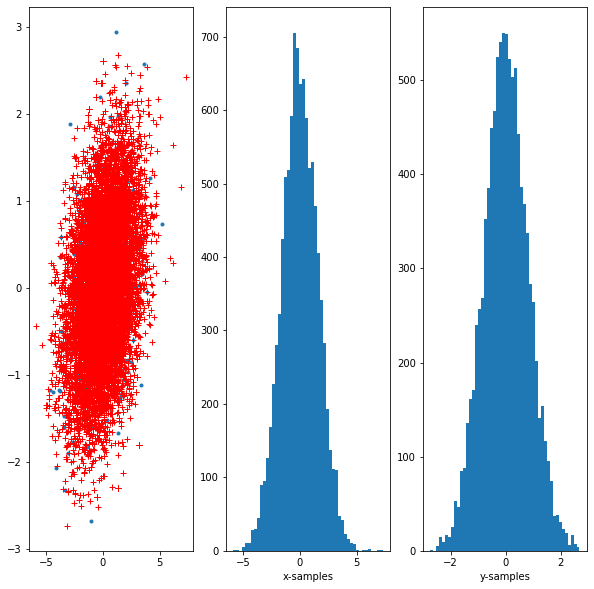

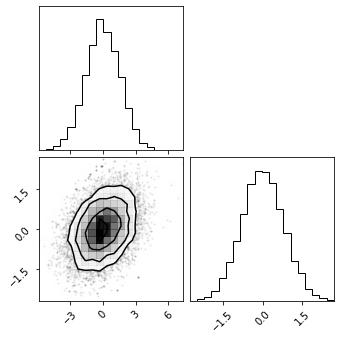